Here is an example/test of specifying the `pixel_gains_file` parameter when running `simulate_pixels.py`. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from larndsim.fee import digitize
from larndsim.consts import *
from larndsim.consts.units import *

In [5]:
# importing larndsim file with 0.1 MeV electrons 
filepath = 'larndsim_0.1MeV_electrons_5000events_no_noise_0.004_0.010_0.020_0.030_0.040_mVpere_choice_gain.h5'
file_gain_file = h5py.File(filepath, 'r')

# uniform gain of 0.004 mV/e
filepath = 'larndsim_0.1MeV_electrons_5000events_no_noise_0.004_mVpere.h5'
file_no_gain_file = h5py.File(filepath, 'r')

packets_gain_file = file_gain_file['packets'][file_gain_file['packets']['packet_type'] == 0]
packets_no_gain_file = file_no_gain_file['packets'][file_no_gain_file['packets']['packet_type'] == 0]

Simulation Parameters:
- 5000 0.1MeV electrons distributed uniformly in module-0 -> Bethe-Bloch eqn says these are ~0.15 mm is length on average
- 1ke- discrimination threshold
- Zero noise (RESET_NOISE_CHARGE, UNCORRELATED_NOISE_CHARGE, and DISCRIMINATOR_NOISE set to 0 to better see effects of differing gains)
- Near infinite electron lifetime (tau = 10ms)
- Recombination factor fixed at 0.5
- Physics list = QGSP_BERT_LIV
- Otherwise default larnd-sim parameters

unique adc values (using gain file) =  [75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97]
unique adc values (not using gain file) =  [75 76]
drifted q =  2118.64406779661  e-
Expected adc values =  [76.0, 79.0, 85.0, 90.0, 95.0]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
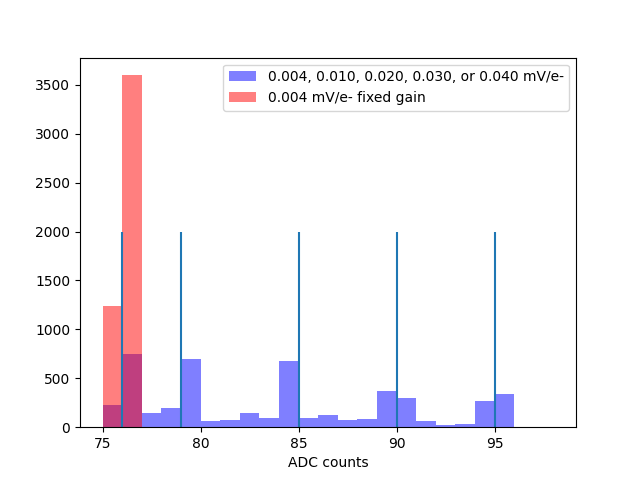

In [15]:
%matplotlib widget
adcs_gain_file = packets_gain_file['dataword']
unique_adcs_gain_file = np.unique(adcs_gain_file)
print('unique adc values (using gain file) = ', unique_adcs_gain_file)

adcs_no_gain_file = packets_no_gain_file['dataword']
unique_adcs_no_gain_file = np.unique(adcs_no_gain_file)
print('unique adc values (not using gain file) = ', unique_adcs_no_gain_file)

E = 0.1 # MeV
q = E*1e6 / 23.6 * 0.5
print('drifted q = ', q, ' e-')

gains = np.array([0.004, 0.010, 0.020, 0.030, 0.040])*mV/e # mV/e
adcs = []
for gain in gains:
    adc = digitize(q, gain)
    adcs.append(adc)
    plt.vlines(adc, ymin=0, ymax = 2000)
print('Expected adc values = ', adcs)

# plot histograms of each case
range_min = np.min(unique_adcs_gain_file)
range_max = np.max(unique_adcs_gain_file)+1
nbins = len(unique_adcs_gain_file)
plt.hist(adcs_gain_file, range = (range_min, range_max), bins=nbins, color='blue', alpha=0.5, label = '0.004, 0.010, 0.020, 0.030, or 0.040 mV/e-')
plt.hist(adcs_no_gain_file, range = (range_min, range_max), bins=nbins, color='red', alpha=0.5, label='0.004 mV/e- fixed gain')
plt.legend()
plt.xlabel('ADC counts')
plt.show()

Given the very small track lengths of the 0.1MeV electrons, the chances are high that the electrons will be completely captured by a single channel (but may not always be the case). In the plot above, we see that we see a single peak (red) when the gain is the same across all channels. When the gain is randomly chosen among five different values, we see five peaks. These peaks are at the expected positions (blue vertical lines). There are also non-zero bins at unexpected ADC counts, but this must be due to certain effects in the simulation. We can conclude from this that we are setting the channel dependent gains correctly in the code, and `larnd-sim` is producing an output consistent with the specified gains.

In [ ]:
# example of creating an npz file to use with the `pixel_gains_file` parameter
import random
keys = np.arange(0, 78400, 1, dtype='int64') # possible pixel ids; mod-0
output_filepath = 'module0-fake_gain.npz'
gains = np.array([0.004, 0.010, 0.020, 0.030, 0.040]) * mV/e
values = np.zeros_like(keys, dtype='float64')

for i in range(len(keys)):
    gain_choice = random.choice(gains)
    values[i] = gain_choice

default = np.array([0.004*mV/e]) # default value for file 
np.savez(output_filepath, keys=keys, values=values, default=default)